# **ML-AI4Econ Course**

We first download the different packages needed for this part of the course:

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingRegressor, AdaBoostClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

We also set a random seed for reproducible results:

In [52]:
np.random.seed(24)

### Bagging Trees

Even though trees seem to be very good, there are some problems with them, such as the fact that they are quite variable (the tree will depend on the dataset) and hence our performance might vary in production. A way to reduce the variance of our model and avoid generalization issues is bagging.

**How Bagging Reduces Variance**

The strength of bagging lies in variance reduction. Suppose each base estimator has a variance of $\sigma^2$, and the covariance between any two estimators is $\rho\sigma^2$. The variance of the aggregated predictor is given by:
$$
\text{Var}(\hat{y}_i) = \frac{1}{M^2} \sum_{m=1}^{M} \text{Var}(\hat{y}_i^{(m)}) + \frac{2}{M^2} \sum_{m < m'} \text{Cov}(\hat{y}_i^{(m)}, \hat{y}_i^{(m')})
$$

If we assume that all base estimators have the same variance and pairwise covariance, this simplifies to:
$$
\text{Var}(\hat{y}_i) = \frac{1}{M}\sigma^2 + \frac{M-1}{M}\rho\sigma^2
$$

When the base models are uncorrelated ($\rho = 0$), the variance of the aggregated prediction reduces to:
$$
\text{Var}(\hat{y}_i) = \frac{\sigma^2}{M}
$$

Thus, by increasing $M$, bagging can significantly reduce the variance, leading to more stable and accurate predictions.

We now use again the california housing dataset in order to compare our results with the ones obtained from the regression tree.

In [53]:
housing = fetch_california_housing()
X = housing.data
y = housing.target

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

This type of ensemble model works for both regression and classification purposes, but we now just focus on regression.

Bagging, short for Bootstrap Aggregating, is an ensemble technique that improves model performance by reducing the variance of predictions. It does so by training multiple base models on different random subsets of the training data and then aggregating their predictions.

**How It Works**

1. **Bootstrap Sampling**  
   Bagging creates $M$ different training sets by sampling from the original data *with replacement*. Each bootstrap sample is used to train a separate base estimator (for example, a decision tree).

2. **Training Base Estimators**  
   Each base estimator learns to predict the target value based on its corresponding bootstrap sample. Let $\hat{y}_i^{(m)}$ denote the prediction for input $x_i$ from the $m$-th model.

3. **Aggregation of Predictions**  
   For regression tasks, the final prediction $\hat{y}_i$ is computed by averaging the predictions of all base estimators:
   $$
   \hat{y}_i = \frac{1}{M} \sum_{m=1}^{M} \hat{y}_i^{(m)}
   $$
   In classification, a majority vote among the base estimators is typically used.

**Estimation Process in Bagging**

The overall procedure for bagging in a regression context is:

- **Step 1: Create Bootstrap Samples**  
  Generate $M$ new training sets by sampling with replacement from the original training data.

- **Step 2: Train Base Estimators**  
  Train a base model (e.g., a decision tree) on each of these bootstrap samples.

- **Step 3: Make Predictions**  
  For a new input $x_i$, each base estimator provides a prediction $\hat{y}_i^{(m)}$.

- **Step 4: Aggregate Predictions**  
  The final prediction is computed by averaging:
  $$
  \hat{y}_i = \frac{1}{M} \sum_{m=1}^{M} \hat{y}_i^{(m)}
  $$

By averaging the predictions, the ensemble method reduces the overall variance and leads to a model that generalizes better on unseen data.


In [55]:
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=50,        # Number of base estimators (trees)
    max_samples=0.8,        # Each tree is trained on 80% of the data
    bootstrap=True,         # Use bootstrapping
    random_state=42
)

bagging_model.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), max_samples=0.8,
                 n_estimators=50, random_state=42)

Now, let us take a look at its performance:

Mean Squared Error (MSE): 0.2643
Mean Absolute Error (MAE): 0.3326
R-squared (R2): 0.7983


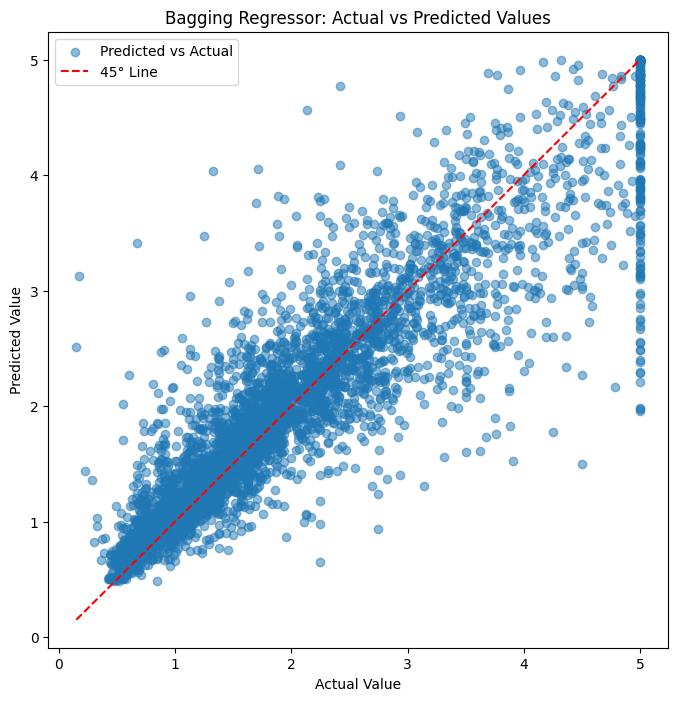

In [56]:
y_pred = bagging_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE): {:.4f}".format(mse))
print("Mean Absolute Error (MAE): {:.4f}".format(mae))
print("R-squared (R2): {:.4f}".format(r2))


plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs Actual")
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="45° Line")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Bagging Regressor: Actual vs Predicted Values")
plt.legend()
plt.show()

As we can see, performance has greatly improved in our model. We will now use GridSearch to further improve our model:

In [57]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 1.0]
}

grid_search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (MSE): {:.4f}".format(-grid_search.best_score_))

Best Parameters: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}
Best CV Score (MSE): 0.2612


Test Mean Squared Error (MSE): 0.2559
Test Mean Absolute Error (MAE): 0.3279
Test R-squared (R2): 0.8047


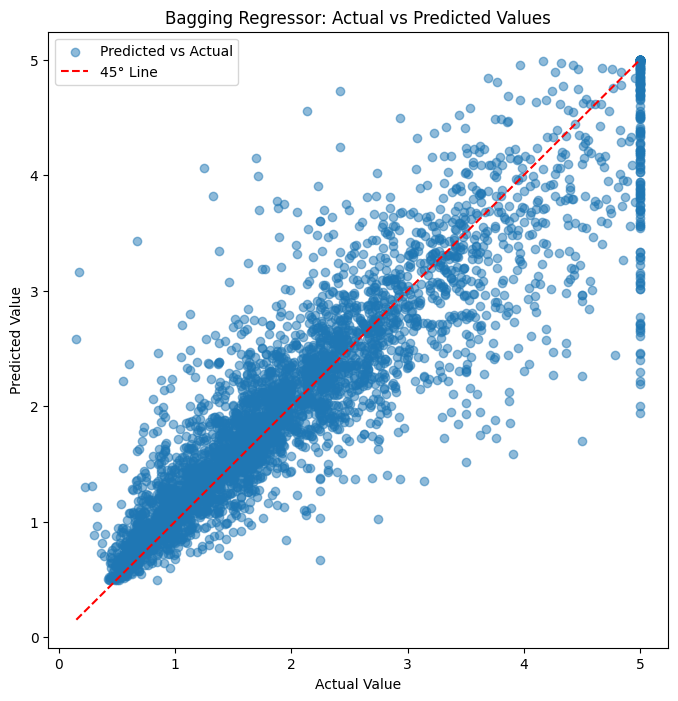

In [58]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("Test Mean Squared Error (MSE): {:.4f}".format(mse))
print("Test Mean Absolute Error (MAE): {:.4f}".format(mae))
print("Test R-squared (R2): {:.4f}".format(r2))

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs Actual")
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="45° Line")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Bagging Regressor: Actual vs Predicted Values")
plt.legend()
plt.show()

### Random Forests

Random Forests are an ensemble method that builds upon the idea of bagging by also introducing random feature selection. This additional randomness reduces the correlation between the individual trees and often improves overall model performance.

**How Random Forests Work**

1. **Bootstrap Sampling:**  

    Each tree is trained on a bootstrap sample (sampling with replacement) of the original dataset, like in bagging.

2. **Random Feature Selection:**  

    At each split in the tree, only a random subset of features is considered to determine the best split. This decorrelates the trees and leads to a more robust ensemble.

3. **Aggregation of Predictions:**  

    - In a regression setting, the final prediction is the average of the predictions from all trees.  
    - In a classification setting, the final prediction is made by majority voting.

Random forests reduce variance by averaging the predictions of many individual decision trees. Suppose that each tree is an estimator with variance $\sigma^2$, and they are roughly uncorrelated. When averaging over $M$ trees, the variance of the ensemble predictor becomes

$$
\operatorname{Var}\left(\hat{y}\right) = \frac{1}{M}\sigma^2.
$$

This shows that as $M$ increases, the variance of the combined predictor decreases proportionally to $\frac{1}{M}$.

Moreover, random forests introduce an additional level of randomness by selecting a random subset of features at each split. This mechanism reduces the correlation between individual trees. If we denote the pairwise correlation between trees as $\rho$, then the variance of the ensemble predictor is more generally given by

$$
\operatorname{Var}\left(\hat{y}\right) = \frac{1}{M}\sigma^2 + \frac{M-1}{M} \rho\,\sigma^2.
$$

With a lower $\rho$, the second term becomes small, and the overall variance is much closer to $\frac{\sigma^2}{M}$. This is the key mathematical intuition behind why random forests, through averaging and decorrelating individual trees, dramatically reduce variance compared to a single decision tree.

We will stick to the regression exercise from above just to see how the performance can improve when reducing the variance of our model.

In [59]:
rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': [0.5, 1.0],
    'max_depth': [None, 10, 20]
}

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

print("Best Parameters:", grid_search_rf.best_params_)
print("Best CV Score (MSE): {:.4f}".format(-grid_search_rf.best_score_))

Best Parameters: {'max_depth': None, 'max_features': 0.5, 'n_estimators': 200}
Best CV Score (MSE): 0.2474


Now, as we can see, the performance is even better because we have reduced correlation!

Test Mean Squared Error (MSE): 0.2469
Test Mean Absolute Error (MAE): 0.3228
Test R-squared (R2): 0.8116


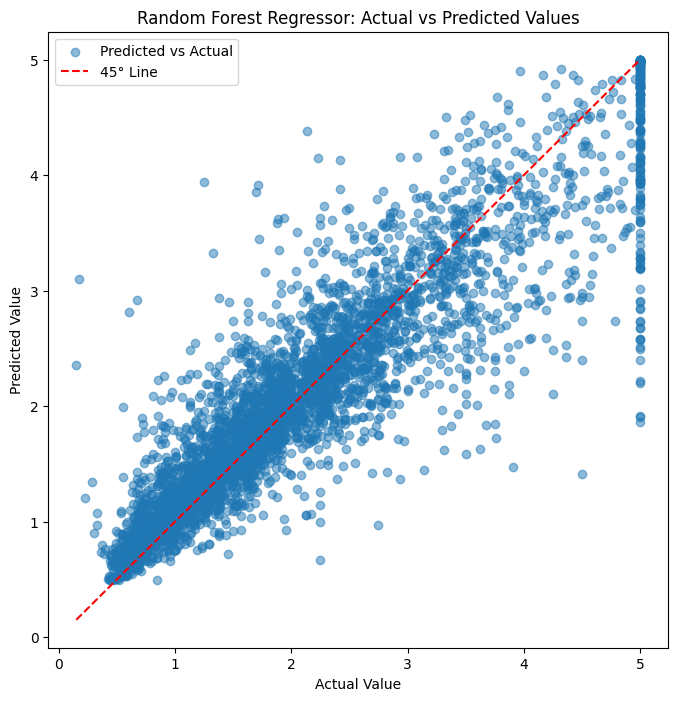

In [60]:

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Test Mean Squared Error (MSE): {:.4f}".format(mse_rf))
print("Test Mean Absolute Error (MAE): {:.4f}".format(mae_rf))
print("Test R-squared (R2): {:.4f}".format(r2_rf))

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Predicted vs Actual")
min_val_rf = min(y_test.min(), y_pred_rf.min())
max_val_rf = max(y_test.max(), y_pred_rf.max())
plt.plot([min_val_rf, max_val_rf], [min_val_rf, max_val_rf], 'r--', label="45° Line")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Random Forest Regressor: Actual vs Predicted Values")
plt.legend()
plt.show()

### Boosting

Boosting is an ensemble technique that builds a strong predictive model by combining multiple weak learners in a sequential manner. Unlike bagging, which trains models independently, boosting focuses on correcting the mistakes of previous models.

1. **Weak Learners:**  

   A weak learner is a model that performs only slightly better than random guessing. Common choices include shallow decision trees (often called decision stumps).

2. **Sequential Training:**  

   Boosting trains weak learners one at a time. Each new learner is trained to correct the errors made by the previous learners.

3. **Weighting of Samples:**  

   Initially, all training samples are given equal weight. After each iteration, the weights of misclassified (or poorly predicted) samples are increased. This forces subsequent learners to focus more on these difficult cases.

For taking a look at boosting, we use the same dataset we used for the classification tree before, so that we can compare the performances.

In [61]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For classification purposes, we choose one of the various boosting algorithms available for classification, and which serves as a usual example: AdaBoost. AdaBoost (Adaptive Boosting) is an ensemble learning method that improves the overall predictive performance by combining multiple weak classifiers. The process involves the following steps:

1. **Sequential Training of Weak Learners:**  

   AdaBoost trains a series of weak classifiers (e.g., decision stumps) sequentially. Initially, all samples are given equal weights.

2. **Emphasis on Misclassified Samples:**  

   After each weak classifier is trained, the weights of the misclassified samples are increased. This forces the next classifier to focus more on the difficult cases. Mathematically, the weighted error for the $m$-th classifier is computed as:
   $$
   \epsilon_m = \frac{\sum_{i=1}^{N} w_i \cdot I(y_i \neq h_m(x_i))}{\sum_{i=1}^{N} w_i}
   $$
   where $I(\cdot)$ is the indicator function, $w_i$ is the weight for sample $i$, and $h_m(x_i)$ is the prediction of the $m$-th classifier.

3. **Combining Weak Learners:**  

   Each classifier is assigned a weight based on its performance:
   $$
   \alpha_m = \ln\left(\frac{1 - \epsilon_m}{\epsilon_m}\right)
   $$
   The final prediction is then given by a weighted majority vote:
   $$
   \hat{y} = \text{sign}\left(\sum_{m=1}^{M} \alpha_m \cdot h_m(x)\right)
   $$
   For classification, the sign function determines the class label.

**How AdaBoost is Estimated**

The estimation process in AdaBoost involves:

- **Initialization:**  

  Start with equal weights for all training samples.

- **Iterative Update:**  

  For each weak learner:
  - Train the classifier on the weighted training data.
  - Calculate the weighted error $\epsilon_m$.
  - Compute the classifier's weight $\alpha_m$.
  - Update the sample weights:
    $$
    w_i \leftarrow w_i \cdot \exp\left(\alpha_m \cdot I(y_i \neq h_m(x_i))\right)
    $$
  - Normalize the weights so that they sum to 1.

- **Aggregation:**  

  After $M$ iterations, the final classifier is a combination of all weak learners, where each contributes according to its weight $\alpha_m$.

This method improves predictions by reducing bias through the combined decision of multiple classifiers and reducing variance by averaging out errors. The focus on misclassified samples in each iteration ensures that the ensemble becomes progressively better at handling difficult cases.

In [63]:
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # Weak learners (decision stumps)
    n_estimators=50,         # Number of weak classifiers
    learning_rate=1.0,
    random_state=42
)

ada_model.fit(X_train, y_train)

c:\Users\Iker\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

Look at what happens with the performance:

Accuracy: 0.9737
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



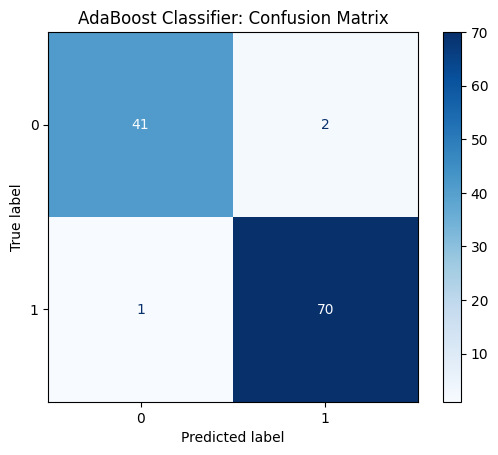

In [64]:
y_pred = ada_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.4f}".format(accuracy))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("AdaBoost Classifier: Confusion Matrix")
plt.show()

We will now use GridSearch to further improve our model (if possible):

In [65]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.5, 1.0, 1.5]
}

grid_search = GridSearchCV(
    estimator=ada_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy: {:.4f}".format(grid_search.best_score_))

c:\Users\Iker\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best Parameters: {'learning_rate': 1.0, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.9736


Test Accuracy: 0.9737
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



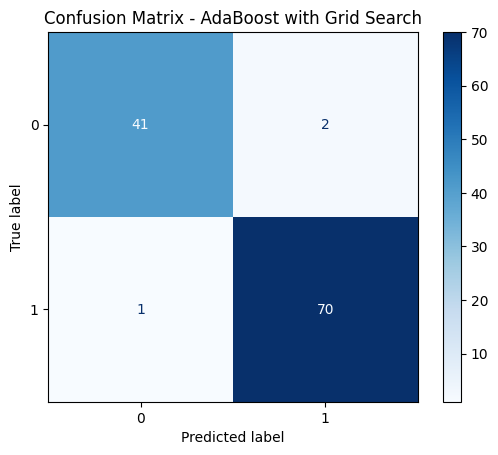

In [66]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.4f}".format(accuracy))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - AdaBoost with Grid Search")
plt.show()

# Exercises
Now there are a bunch of exercises for testing your understanding. Please do not use LLMs or ChatGPT to answer them (unless you are explicitly ordered to do so), but look at the documentation of different packages and websites for a better control of Python packages for ML \& AI.

### **Exercise 1: Understanding Bagging**
**Objective:** Understand the core mechanism behind bagging.
- Explain how bootstrap sampling (sampling with replacement) contributes to reducing the variance of predictions.
- If each base estimator has a variance of $\sigma^2$, what is the aggregated variance for $M$ uncorrelated estimators?

### **Exercise 2: Empirical Impact of Bagging**
**Objective:** Analyze the effects of bagging on model performance.
- How does changing the parameter `max_samples` (e.g., from 0.8 to 1.0) affect our predictions?
- What metrics would you compare to assess the improvement in variance reduction?

### **Exercise 3: Aggregation in Bagging**
**Objective:** Look at the aggregation process within bagging.
- For regression, why do we average the predictions? What mathematical property of the mean helps in variance reduction?
- How would the aggregation differ in a classification scenario?

### **Exercise 4: The Role of Base Estimators**
**Objective:** Deep dive into the choice and behavior of base estimators in bagging.
- How does the complexity of a Decision Tree regressor influence the overall performance of a Bagging ensemble?
- Why might an ensemble with simpler base models sometimes outperform one with highly complex models?

### **Exercise 5: Evaluating Ensemble Performance**
**Objective:** Empirically assess model performance metrics.
- How can metrics like $MSE$, $MAE$, and $R^2$ be used to compare a single Decision Tree with a Bagging ensemble?
- What do the changes in these metrics imply about the bias-variance trade-off?

### **Exercise 6: Fundamentals of Boosting**
**Objective:** Understand the sequential nature of boosting.
- Describe the process of how boosting iteratively improves the model by focusing on previously misclassified or poorly predicted examples.
- How does the computation of the weighted error $\epsilon_m$ influence the weight $\alpha_m$ assigned to each weak learner?

### **Exercise 7: Weight Update Mechanism in AdaBoost**
**Objective:** Analyze the weight update rules in AdaBoost.
- Explain the formula $w_i \leftarrow w_i \cdot \exp\left(\alpha_m \cdot I(y_i \neq h_m(x_i))\right)$ and its impact on training subsequent weak learners.
- How does normalizing the weights after each iteration help in stabilizing the training process?

### **Exercise 8: Influence of Learning Rate**
**Objective:** Explore the role of the learning rate in boosting.
- Discuss how adjusting the `learning_rate` parameter might affect the contribution $\alpha_m = \ln\left(\frac{1-\epsilon_m}{\epsilon_m}\right)$ of each weak learner.
- What trade-offs do you observe when the learning rate is decreased or increased?

### **Exercise 9: Sequential vs. Parallel Training in Ensembles**
**Objective:** Compare the two paradigms of ensemble methods.
- Contrast the sequential training in boosting with the parallel training in bagging. How does each impact model diversity and performance?
- In what scenarios might one prefer boosting over bagging or vice versa?

### **Exercise 10: Empirical Evaluation with Confusion Matrix**
**Objective:** Assess classification performance in a boosting framework.
- How can a confusion matrix be used to interpret the performance of an AdaBoost classifier?
- Identify potential pitfalls when interpreting accuracy from a confusion matrix, especially in imbalanced datasets.